<a href="https://colab.research.google.com/github/chetankhairnar05/Colab/blob/main/cat_dog_image_classification_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -O cat_dog.zip "https://www.kaggle.com/api/v1/datasets/download/bhavikjikadara/dog-and-cat-classification-dataset"

# Step 2: Unzip the file
!unzip cat_dog.zip -d cat_dog

# Step 3: Check files
!ls cat_dog




In [2]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


In [3]:
# #####
# GPU acceleration: tf.image ops run on GPU.

# Batch size: 4000 is safe for T4 (12 GB RAM, 16 GB VRAM).

# No re-augmentation: file list is frozen before augmentation.

# 3 augmentations per image → ~75k new images per class (if 25k originals).
#######
import os
import tensorflow as tf
from pathlib import Path
from PIL import Image

# Root dirs
root = Path("/content/cat_dog/PetImages")
cat_dir = root / "Cat"
dog_dir = root / "Dog"

cat_files = list(cat_dir.glob("*.jpg"))
dog_files = list(dog_dir.glob("*.jpg"))
print(f"Cats: {len(cat_files)}, Dogs: {len(dog_files)}")

target_size = (256, 256)

# -----------------------------
# GPU augmentations with tf.image
# -----------------------------
def tf_augmentations(img):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, 0.7, 1.3)
    img = tf.image.random_saturation(img, 0.7, 1.3)
    img = tf.image.resize_with_crop_or_pad(img, target_size[0]+20, target_size[1]+20)
    img = tf.image.random_crop(img, size=[target_size[0], target_size[1], 3])
    return img

# -----------------------------
# Batch augment + save
# -----------------------------
def augment_and_save_gpu(files, save_dir, batch_size=4000, aug_per_image=3):
    total = len(files)
    for start in range(0, total, batch_size):
        end = min(start + batch_size, total)
        batch_files = files[start:end]

        imgs = []
        names = []
        for f in batch_files:
            try:
                img = tf.io.decode_jpeg(tf.io.read_file(str(f)), channels=3)
                img = tf.image.resize(img, target_size)
                img = tf.cast(img, tf.uint8)
                imgs.append(img)
                names.append(f.stem)
            except:
                continue

        imgs = tf.stack(imgs)  # now in GPU
        for j in range(aug_per_image):
            aug_imgs = tf.map_fn(tf_augmentations, imgs)
            aug_imgs = tf.cast(aug_imgs, tf.uint8).numpy()  # back to numpy for saving

            for k, aug in enumerate(aug_imgs):
                out_path = os.path.join(save_dir, f"{names[k]}_aug{j}.jpg")
                Image.fromarray(aug).save(out_path)

        print(f"✅ Processed {end}/{total} images in {save_dir}")

# -----------------------------
# Run for Cats and Dogs
# -----------------------------
augment_and_save_gpu(cat_files, str(cat_dir), batch_size=4000, aug_per_image=3)
augment_and_save_gpu(dog_files, str(dog_dir), batch_size=4000, aug_per_image=3)

print("🎉 All augmentations done (GPU accelerated)")


Cats: 12499, Dogs: 12499
✅ Processed 4000/12499 images in /content/cat_dog/PetImages/Cat
✅ Processed 8000/12499 images in /content/cat_dog/PetImages/Cat
✅ Processed 12000/12499 images in /content/cat_dog/PetImages/Cat
✅ Processed 12499/12499 images in /content/cat_dog/PetImages/Cat
✅ Processed 4000/12499 images in /content/cat_dog/PetImages/Dog
✅ Processed 8000/12499 images in /content/cat_dog/PetImages/Dog
✅ Processed 12000/12499 images in /content/cat_dog/PetImages/Dog
✅ Processed 12499/12499 images in /content/cat_dog/PetImages/Dog
🎉 All augmentations done (GPU accelerated)


In [ ]:
#########
# ways to reduce overfitting
# Add more data
# Data Augmentation -> next video
# # VI/L2 Reg4artzer
# Dropout
# Batch Norm
# Reduce complexity
#########

In [5]:
import os

# Paths to your folders
cats_dir = "/content/cat_dog/PetImages/Cat"
dogs_dir = "/content/cat_dog/PetImages/Dog"

# Count images
num_cats = len([f for f in os.listdir(cats_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
num_dogs = len([f for f in os.listdir(dogs_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

print(f"Total Cat images: {num_cats}")
print(f"Total Dog images: {num_dogs}")
print(f"Total Images: {num_cats + num_dogs}")


Total Cat images: 49780
Total Dog images: 49690
Total Images: 99470


In [6]:
# Cell 1: Import libraries
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report


In [7]:
# Cell 2: Define paths
cats_dir = "/content/cat_dog/PetImages/Cat"
dogs_dir = "/content/cat_dog/PetImages/Dog"
base_dir = "/content/cat_dog/PetImages"

# Data generators with split
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.5  # 50% for train+val
)

train_gen = datagen.flow_from_directory(
    base_dir,
    target_size=(128,128),
    batch_size=64,
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=42
)

val_gen = datagen.flow_from_directory(
    base_dir,
    target_size=(128,128),
    batch_size=64,
    class_mode="binary",
    subset="validation",
    shuffle=True,
    seed=42
)

# Test generator separately (20% test later)
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    base_dir,
    target_size=(128,128),
    batch_size=64,
    class_mode="binary",
    shuffle=True,
    seed=42
)


Found 49735 images belonging to 2 classes.
Found 49735 images belonging to 2 classes.
Found 99470 images belonging to 2 classes.


In [8]:
# Cell 3: Build model with ReLU family (LeakyReLU)
model = models.Sequential()

# Block 1
model.add(layers.Conv2D(32, (3,3), kernel_regularizer=regularizers.l2(0.001), input_shape=(128,128,3)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.2))

# Block 2
model.add(layers.Conv2D(64, (3,3), kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.2))

# Block 3
model.add(layers.Conv2D(128, (3,3), kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.3))

# Flatten + ANN
model.add(layers.Flatten())
model.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(56, kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dropout(0.3))

# Output layer
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 56)             │         7,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56)             │           224 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,313,553 (12.64 MB)

 Trainable params: 3,312,737 (12.64 MB)

 Non-trainable params: 816 (3.19 KB)

In [9]:
# Cell 4: Compile
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 56)             │         7,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56)             │           224 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,313,553 (12.64 MB)

 Trainable params: 3,312,737 (12.64 MB)

 Non-trainable params: 816 (3.19 KB)

In [11]:
# Cell 5: Train with validation
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20
)


Epoch 1/20
291/778 ━━━━━━━━━━━━━━━━━━━━ 37s 77ms/step - accuracy: 0.5957 - loss: 1.2037

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


778/778 ━━━━━━━━━━━━━━━━━━━━ 124s 159ms/step - accuracy: 0.6346 - loss: 1.0723 - val_accuracy: 0.7052 - val_loss: 0.7823
Epoch 2/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 107s 137ms/step - accuracy: 0.7355 - loss: 0.7333 - val_accuracy: 0.7462 - val_loss: 0.7134
Epoch 3/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 140s 179ms/step - accuracy: 0.7662 - loss: 0.6878 - val_accuracy: 0.6661 - val_loss: 0.8850
Epoch 4/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 108s 139ms/step - accuracy: 0.7741 - loss: 0.6748 - val_accuracy: 0.6423 - val_loss: 0.9096
Epoch 5/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 113s 145ms/step - accuracy: 0.7805 - loss: 0.6717 - val_accuracy: 0.7838 - val_loss: 0.6724
Epoch 6/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 115s 147ms/step - accuracy: 0.7967 - loss: 0.6564 - val_accuracy: 0.7698 - val_loss: 0.6798
Epoch 7/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 142s 182ms/step - accuracy: 0.8036 - loss: 0.6389 - val_accuracy: 0.8060 - val_loss: 0.6374
Epoch 8/20
778/778 ━━━━━━━━━━━━━━━━━━━━ 110s 142ms/step - accuracy: 0.8070 - loss: 0.63

In [12]:
# Cell 6: Evaluate
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")


1555/1555 ━━━━━━━━━━━━━━━━━━━━ 103s 66ms/step - accuracy: 0.7352 - loss: 0.8138
Test Accuracy: 0.7345


1555/1555 ━━━━━━━━━━━━━━━━━━━━ 108s 69ms/step


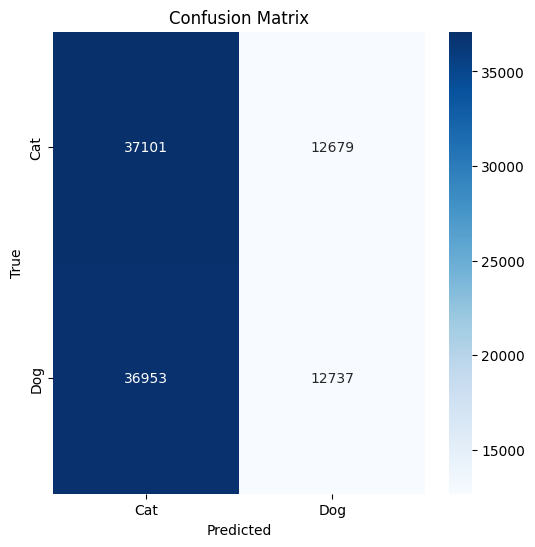

              precision    recall  f1-score   support

         Cat       0.50      0.75      0.60     49780
         Dog       0.50      0.26      0.34     49690

    accuracy                           0.50     99470
   macro avg       0.50      0.50      0.47     99470
weighted avg       0.50      0.50      0.47     99470



In [13]:
# Cell 7: Confusion Matrix
y_true = test_gen.classes
y_pred = model.predict(test_gen, verbose=1)
y_pred_classes = (y_pred > 0.5).astype("int32").ravel()

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Cat","Dog"], yticklabels=["Cat","Dog"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=["Cat","Dog"]))


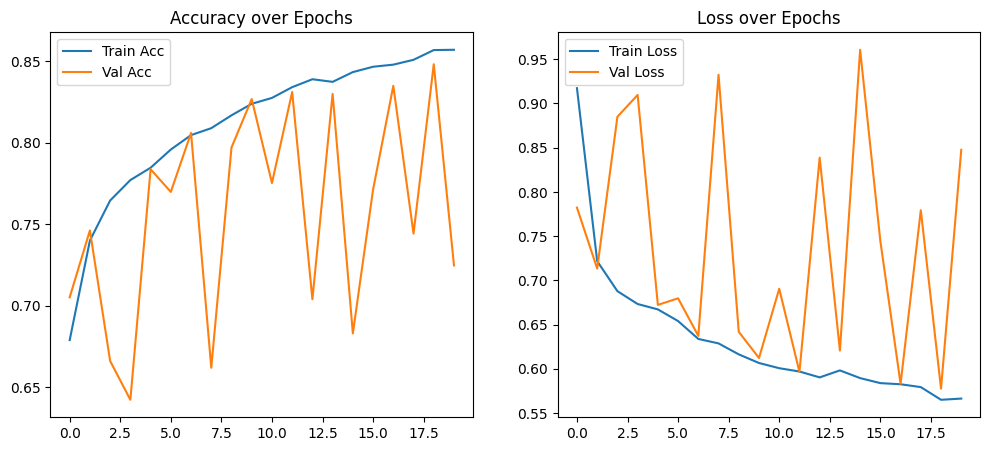

In [14]:
# Cell 8: Plot learning curves
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy over Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.show()
